In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [11]:
# Download latest version
directory = 'enfermedades-cacao-yolov4/'

print("Path to dataset files:", directory)

Path to dataset files: enfermedades-cacao-yolov4/


In [12]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['Fito', 'Sana', 'Monilia']
3


In [13]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N))     
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [15]:
dataset=[]
datafile=[]
datapath=[]
boxset=[]
boxfile=[]
boxpath=[]

count=0
for file in os.listdir(directory):
    path=os.path.join(directory,file)
    for im in os.listdir(path):
        if im[-4:]=='.jpg':
            image=load_img(os.path.join(path,im), color_mode='rgb', target_size=(100,100))
            
            image=img_to_array(image)
            image=image/255.0
            dataset.append([image,count])
            datafile.append(im)
            bx=im[0:-4]+'.txt'
            boxfile.append(bx)
            dtpath=os.path.join(path,im)
            datapath.append(dtpath)
            bxpath=os.path.join(path,bx)
            bxdata=np.loadtxt(bxpath)            
            boxpath.append(bxpath)
            boxset.append(bxdata)
    count=count+1

In [16]:
n_sana=0
n_monilia=0
n_fito=0
for i in range(len(dataset)):
    sp=dataset[i][1]
    if sp==0:
        n_sana+=1
    elif sp==1:
        n_monilia+=1
    elif sp==2:
        n_fito+=1
        
print(n_fito,n_monilia,n_sana)
print(len(dataset))

105 100 107
312


In [34]:
def cacao_delimitador(num0):
    """
    Dibuja una imagen con cuadros delimitadores (bounding boxes) sobre ella,
    extrae las regiones dentro de los cuadros y las muestra solo si no son 'Sana' (amarillo).
    
    Parámetros:
    num0 (int): Índice de la imagen en el dataset que se desea visualizar.
    
    El código realiza los siguientes pasos:
    1. Carga la imagen y obtiene las coordenadas del cuadro delimitador.
    2. Muestra la imagen usando `matplotlib`.
    3. Añade texto sobre la imagen (como el nombre y números).
    4. Dibuja uno o más cuadros delimitadores sobre la imagen.
    5. Extrae las regiones dentro de los cuadros solo si no son 'Sana' y las muestra.
    """
    
    # Obtener la ruta de la imagen, el cuadro delimitador y el 'count' para el nombre.
    img0 = datapath[num0]  # Ruta de la imagen
    box0 = boxset[num0]  # Cuadro delimitador de la imagen
    count = dataset[num0][1]  # El 'count' del dataset (probablemente el label)
    name = mapper(count)  # Mapper que convierte el 'count' en un nombre
    
    # Abrir la imagen con PIL
    im = Image.open(img0)
    W, H = im.size  # Obtener el tamaño de la imagen (ancho y altura)
    
    # Crear una figura para visualizar la imagen
    plt.figure(figsize=(10, 10))  # Establecer tamaño de la figura
    plt.axis('on')  # Activar los ejes
    plt.imshow(mpimg.imread(img0))  # Leer y mostrar la imagen
    
    # Obtener el objeto de los ejes (ax) para poder añadir texto y elementos gráficos
    ax = plt.gca()
    
    # Añadir texto sobre la imagen
    ax.text(W*0.05, H*0.05, f'{name}', fontsize=30, color='yellow')  # Nombre en amarillo
    ax.text(W*0.05, H*0.10, f'#0', fontsize=20, color='red')  # Texto '#0' en rojo
    ax.text(W*0.05, H*0.15, f'#1', fontsize=20, color='blue')  # Texto '#1' en azul
    ax.text(W*0.05, H*0.20, f'#2', fontsize=20, color='yellow')  # Texto '#2' en amarillo
    
    # Definir los colores en un diccionario
    color_map = {
        0: 'red',   # Rojo para 'Fito'
        1: 'blue',  # Azul para 'Monilia'
        2: 'yellow' # Amarillo para 'Sana' (no se mostrará)
    }
    
    # Crear una lista para almacenar las regiones extraídas que no son 'Sana'
    extracted_regions = []
    
    # Verificar si 'box0' es un solo cuadro delimitador
    if type(box0[0]) == np.float64:
        # Si es un solo cuadro, descomponer sus componentes
        mk, x0, y0, w0, h0 = box0
        # Convertir las coordenadas normalizadas a píxeles
        x = int((x0 - w0 / 2) * W)
        y = int((y0 - h0 / 2) * H)
        w = int(w0 * W)
        h = int(h0 * H)
        
        # Si el cuadro no es 'Sana' (no amarillo), extraerlo
        if mk != 2:
            # Extraer la región dentro del cuadro delimitador
            region = im.crop((x, y, x + w, y + h))
            extracted_regions.append(region)
        
        # Dibujar el cuadro delimitador en la imagen
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_map.get(mk, 'gray'), fill=False)
        ax.add_patch(rect)
    
    else:
        # Si 'box0' contiene múltiples cuadros delimitadores, iterar sobre ellos
        for item in box0:
            mk, x0, y0, w0, h0 = item
            # Convertir las coordenadas normalizadas a píxeles
            x = int((x0 - w0 / 2) * W)
            y = int((y0 - h0 / 2) * H)
            w = int(w0 * W)
            h = int(h0 * H)
            
            # Si el cuadro no es 'Sana' (no amarillo), extraerlo
            if mk != 2:
                # Extraer la región dentro del cuadro delimitador
                region = im.crop((x, y, x + w, y + h))
                extracted_regions.append(region)
            
            # Dibujar el cuadro delimitador en la imagen
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_map.get(mk, 'gray'), fill=False)
            ax.add_patch(rect)
    
    # Mostrar la imagen con los cuadros delimitadores
    plt.show()

    # Mostrar las regiones extraídas que no son 'Sana' (amarillo)
    for idx, region in enumerate(extracted_regions):
        plt.figure(figsize=(5, 5))
        plt.imshow(region)
        plt.title(f'Region {idx + 1}')
        plt.axis('off')  
        plt.show()

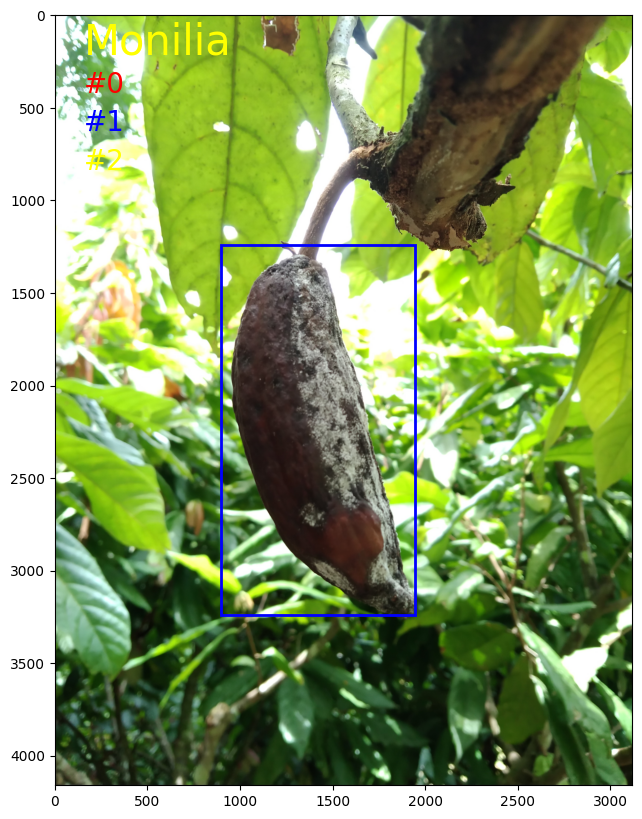

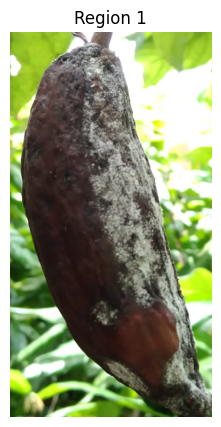

In [35]:
cacao_delimitador(240)

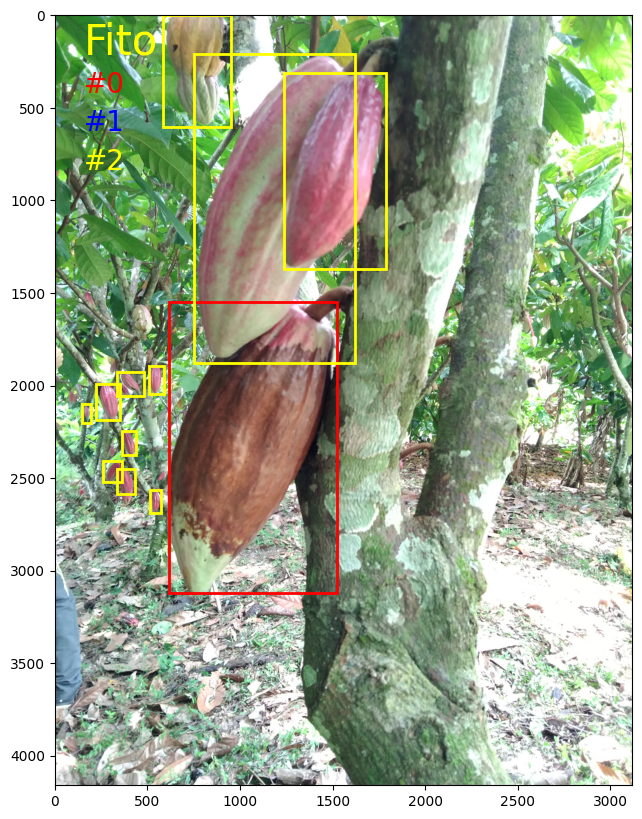

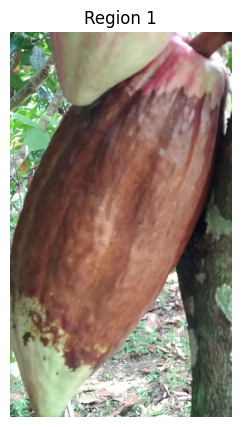

In [37]:
cacao_delimitador(48)

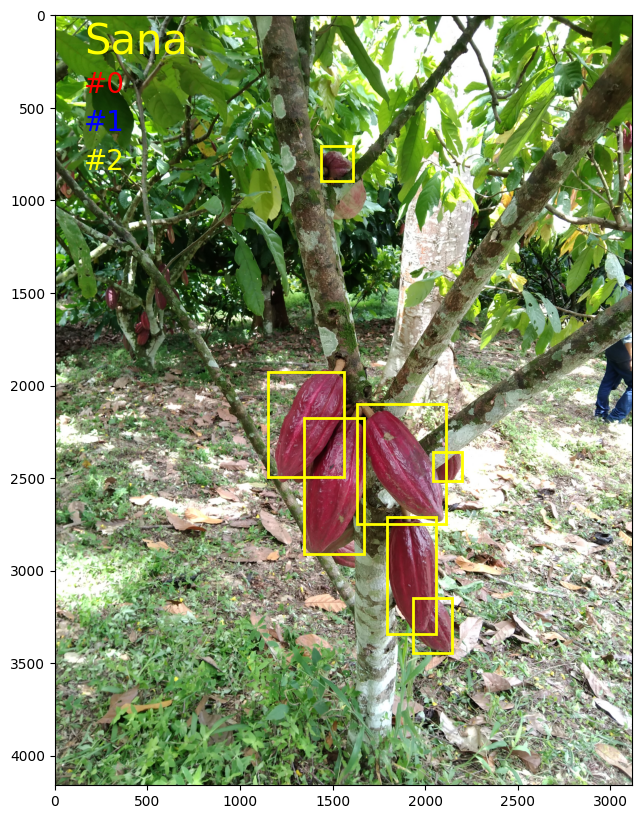

In [38]:
cacao_delimitador(146)

In [41]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Definir las rutas
dataset_dir = 'enfermedades-cacao-yolov4/'
output_dir = './processed_dataset/'

# Crear directorios para train y val
os.makedirs(os.path.join(output_dir, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/labels'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/labels'), exist_ok=True)

# Preparar las listas de imágenes y anotaciones
image_paths = []
label_paths = []

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(folder_path, file))
            label_paths.append(os.path.join(folder_path, file.replace('.jpg', '.txt')))

# Dividir en entrenamiento y validación
train_images, val_images, train_labels, val_labels = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

# Mover los archivos a las carpetas correspondientes
def move_files(images, labels, split):
    for img, lbl in zip(images, labels):
        shutil.copy(img, os.path.join(output_dir, f'{split}/images', os.path.basename(img)))
        shutil.copy(lbl, os.path.join(output_dir, f'{split}/labels', os.path.basename(lbl)))

move_files(train_images, train_labels, 'train')
move_files(val_images, val_labels, 'val')


In [ ]:
# Clona el repositorio oficial de YOLOv5
!git clone https://github.com/ultralytics/yolov5.git

# Cambia al directorio de YOLOv5
%cd yolov5

# Instala los requisitos necesarios
!pip install -r requirements.txt


In [ ]:
# Cambia al directorio de YOLOv5
%cd /home/j/Downloads/CEIA-AGRI-TP
!python yolov5/train.py --img 640 --batch 16 --epochs 50 --data cacao.yaml --weights yolov5s.pt

/home/j/Downloads/CEIA-AGRI-TP
2024-12-08 17:13:21.083486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733696001.137821 2318672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733696001.156097 2318672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=cacao.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, w

In [ ]:
#Evaluar el Modelo
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source ./data/val/images

In [ ]:
#Exportar el Modelo
!python export.py --weights runs/train/exp/weights/best.pt --include tflite onnx

In [ ]:
from IPython.display import Image

# Visualiza una de las imágenes procesadas
Image(filename='runs/detect/exp/image0.jpg') 
